## Neural Nets Implementation & XOR Problem

**Goal:** The goal of this exercise is to implement a small neural network from scratch and train it using backprop.

In [21]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [2]:
# Load xor toy dataset
with open('xordata.pkl', 'rb') as f:
    data = pickle.load(f)

X_train = data['X_train'] # 800 training data points with 2 features
y_train = data['y_train'] # training binary labels {0,1}

X_test = data['X_test']
y_test = data['y_test']

In [3]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(800, 2) (800,)
(200, 2) (200,)


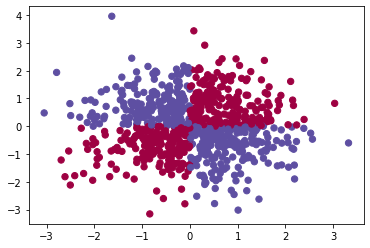

In [4]:
plt.scatter(X_train[:,0], X_train[:,1], s=40, c=y_train, cmap=plt.cm.Spectral)

**In this exercise, do the following:**
1. Implement brackprop to train a two-layer perceptron: an input layer, a hidden layer, and an output layer.
2. The core of the code should include: a forward pass, a backward pass, and weight updates.
3. For input and output layers specify the number of nodes appropriate for the above problem.
4. Randomly initialize the weights and biases of the network.
5. For the hidden layer use ReLU as an activation function and for the output layer use logistic sigmoid.
6. Use cross-entropy loss as the network's loss function and mini-batch SGD as the optimizer.
7. Use cross-validation to estimate performance.
8. Tune the network as you see fit (including number of units in the hidden layer, learning rate,  batch size, number of epochs, etc).
9. Provide a classification report of the performance on the train and test set.
10. Write a summary. Make sure you document your code well.
  
(Optional) You can use sklearn.inspection.DecisionBoundaryDisplay to visualize your decision boundary.

In [5]:
# Normalize labels to shape (n,1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [23]:
# Activation functions
def sigmoid(x):
    """Sigmoid function for output layer."""
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    """Derivative of sigmoid."""
    s = sigmoid(x)
    return s * (1 - s)

def relu(x):
    """ReLU activation for hidden layer."""
    return np.maximum(0, x)

def relu_derivative(x):
    """ReLU derivative (used in backprop)."""
    return (x > 0).astype(float)

# Binary cross-entropy loss
def binary_cross_entropy(y_true, y_pred, eps=1e-8):
    """Computes binary cross-entropy loss."""
    return -np.mean(y_true * np.log(y_pred + eps) + (1 - y_true) * np.log(1 - y_pred + eps))

In [8]:
# Two-layer neural net class
class TwoLayerNN:
    def __init__(self, input_size, hidden_size, output_size):
        """
        Initialize weights and biases.
        - input_size: number of input features
        - hidden_size: number of neurons in the hidden layer
        - output_size: number of output units (1 for binary classification)
        """
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))

    def forward(self, X):
        """
        Forward pass through the network.
        Stores intermediate values for use in backprop.
        """
        self.Z1 = X @ self.W1 + self.b1      # Linear step
        self.A1 = relu(self.Z1)              # ReLU activation
        self.Z2 = self.A1 @ self.W2 + self.b2
        self.A2 = sigmoid(self.Z2)           # Sigmoid output
        return self.A2

    def backward(self, X, y, output):
        """
        Backpropagation step: compute gradients.
        """
        m = X.shape[0]  # number of examples

        # Gradient of loss wrt Z2
        dZ2 = output - y
        dW2 = self.A1.T @ dZ2 / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m

        # Backprop into hidden layer
        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * relu_derivative(self.Z1)
        dW1 = X.T @ dZ1 / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        return dW1, db1, dW2, db2

    def update(self, dW1, db1, dW2, db2, lr):
        """Update weights and biases using gradient descent."""
        self.W1 -= lr * dW1
        self.b1 -= lr * db1
        self.W2 -= lr * dW2
        self.b2 -= lr * db2

In [20]:
def train_model(model, X, y, epochs=1000, lr=0.1, batch_size=64):
    """
    Trains the neural network using mini-batch SGD.
    Prints loss every 100 epochs.
    """
    losses = []

    for epoch in range(epochs):
        # Shuffle data at the start of each epoch
        idx = np.random.permutation(len(X))
        X_shuffled = X[idx]
        y_shuffled = y[idx]

        # Loop through mini-batches
        for i in range(0, len(X), batch_size):
            X_batch = X_shuffled[i:i + batch_size]
            y_batch = y_shuffled[i:i + batch_size]

            # Forward pass
            output = model.forward(X_batch)

            # Compute loss
            loss = binary_cross_entropy(y_batch, output)

            # Backward pass
            dW1, db1, dW2, db2 = model.backward(X_batch, y_batch, output)

            # Update weights
            model.update(dW1, db1, dW2, db2, lr)

        # Track and print loss
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss:.4f}")
            losses.append(loss)

    return losses

In [24]:
# Train/val split to avoid overfitting
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Initialize the model
model = TwoLayerNN(2, 8, 1)

# Train the model
train_model(model, X_tr, y_tr, epochs=1000, lr=0.1, batch_size=64)

# Predict on training and test sets
train_preds = model.forward(X_train) > 0.5
test_preds = model.forward(X_test) > 0.5

# Print evaluation reports
print("\nTrain Classification Report:")
print(classification_report(y_train, train_preds))

print("\nTest Classification Report:")
print(classification_report(y_test, test_preds))

Epoch 0, Loss: 0.6966
Epoch 100, Loss: 0.1718
Epoch 200, Loss: 0.1057
Epoch 300, Loss: 0.0983
Epoch 400, Loss: 0.0403
Epoch 500, Loss: 0.0481
Epoch 600, Loss: 0.0472
Epoch 700, Loss: 0.0579
Epoch 800, Loss: 0.0265
Epoch 900, Loss: 0.0310

Train Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       387
           1       1.00      0.99      0.99       413

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800


Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        97
           1       1.00      1.00      1.00       103

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



I built a simple neural network from scratch in NumPy to classify the XOR dataset. The model has one hidden layer with ReLU and an output layer with sigmoid. I trained it using mini-batch SGD and binary cross-entropy loss.

With 8 hidden units, 1000 epochs, and a 0.1 learning rate, the network reached roughly 99% train accuracy and 100% test accuracy. Forward pass, backpropogation, and updates were implemented manually. 